In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats as st
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statistics import mean
import ast

warnings.filterwarnings('ignore')

# Experiment 1: Measure Quality
Compare achieved standard deviation for the following settings
- Naive Repair: execute old plan, and skip steps that are not possible any more
- Replanning: 
- Replanning with Seed: 

In [21]:
def exp1_prepare_results(folder_path, visualize = False):
    files = os.listdir(os.path.join('.', folder_path))
    mean = pd.DataFrame(columns = ["Option", "Initial Plan", "STD after Disturbance", "Naive Repair", "Replanning", "Replanning (seed 0.2)"])
    std = pd.DataFrame(columns = ["Option", "Naive Repair", "Replanning", "Replanning (seed 0.2)"])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path, f))
            mean_row = {}
            std_row = {}
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_naive_2" or name == "NSGAII_NaivePlanningStrategy_2" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_naive_0"):
                    mean_row["Naive Repair"] = round(group['final_objective_value'].median(), 3)
                    mean_row["Initial Plan"] = round(group['initial_planning_objective'].median(), 3)
                    mean_row["STD after Disturbance"] = round(group['initial_post_disturbance_std'].median(), 3)
                    std_row["Naive Repair"] = round(group['final_objective_value'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["final_objective_value"], label = "Naive repair")
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0" or name == "NSGAII_EvaluationReplanningStrategy-10000_1" or name == "NSGAII_EvaluationReplanningStrategy-10000_0" or name == "NSGAII_PlanningStrategy-ReplanningStrategy_1"):
                    mean_row["Replanning"] = round(group['final_objective_value'].median(), 3)
                    std_row["Replanning"] = round(group['final_objective_value'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["final_objective_value"], label = "Replan")
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0,10_1" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withReinit_0" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withSeed_1" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_2"):
                    mean_row["Replanning (seed 0.2)"] = round(group['final_objective_value'].median(), 3)
                    std_row["Replanning (seed 0.2)"] = round(group['final_objective_value'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["final_objective_value"], label = "Replan with Seed")

            mean_row["Option"] = f.split("@")[1].split("_errPerDisturbance-5")[0]
            mean = mean.append(mean_row, ignore_index = True)
            std_row["Option"] = f.split("@")[1].split("_errPerDisturbance-5")[0]
            std = std.append(std_row, ignore_index = True)
            if visualize:
                plt.title(f.split("@")[1].split("_errPerDisturbance-5")[0])
                plt.legend()
                plt.show()
    return (mean, std)
    
def exp1_relative_values(absolute_values):
    mean_relative = pd.DataFrame(columns = ["Option", "Diff STD after disturbance to initial plan", "Diff Naive Repair to Initial", 
                                           "Diff Replanning to Naive Repair", "Diff seed 0.2 to no seed"])
    mean_relative["Diff STD after disturbance to initial plan"] = (absolute_values["STD after Disturbance"] - absolute_values["Initial Plan"]) / absolute_values["Initial Plan"] * 100
    mean_relative["Diff Naive Repair to Initial"] = (absolute_values["Naive Repair"] - absolute_values["Initial Plan"]) / absolute_values["Initial Plan"] * 100
    mean_relative["Diff Replanning to Naive Repair"] = (absolute_values["Replanning"] - absolute_values["Naive Repair"])/ absolute_values["Naive Repair"] * 100
    mean_relative["Diff seed 0.2 to no seed"] = (absolute_values["Replanning (seed 0.2)"] - absolute_values["Replanning"])/ absolute_values["Replanning"] * 100
    mean_relative["Option"] = absolute_values["Option"]
    mean_relative.round(3)
    return mean_relative

def exp1_merge_absolute_relative(absolute, relative):
    result = pd.DataFrame(columns = ["Option", "Initial Plan", "Naive Repair", "Naive Repair / Initial Plan",
                                     "Replan", "Replan / Naive Repair", "Seed", "Seed / No Seed"])
    result["Option"] = absolute["Option"]
    result["Initial Plan"] = absolute["Initial Plan"]
    result["Naive Repair"] = absolute["Naive Repair"]
    result["Replan"] = absolute["Replanning"]
    result["Seed"] = absolute["Replanning (seed 0.2)"]
    result["Naive Repair / Initial Plan"] = relative["Diff Naive Repair to Initial"]
    result["Replan / Naive Repair"] = relative["Diff Replanning to Naive Repair"]
    result["Seed / No Seed"] = relative["Diff seed 0.2 to no seed"]
    return result

## statistics for fixed plan length (solutionLength = 200)

In [22]:
exp1_mean_simpleModel, exp1_std_simpleModel = exp1_prepare_results("exp1/fixedPlanLength/max10itemsperstack")
exp1_mean_simpleModel_rel = exp1_relative_values(exp1_mean_simpleModel)
exp1_result_simpleModel = exp1_merge_absolute_relative(exp1_mean_simpleModel, exp1_mean_simpleModel_rel)
exp1_mean_complexModel, exp1_std_complexModel = exp1_prepare_results("exp1/fixedPlanLength/max100itemsperstack")
exp1_mean_complexModel_rel = exp1_relative_values(exp1_mean_complexModel)
exp1_result_complexModel = exp1_merge_absolute_relative(exp1_mean_complexModel, exp1_mean_complexModel_rel)
print("Simple Model")
display(exp1_result_simpleModel)
exp1_result_simpleModel.to_csv("exp1_table_simpleModel.csv", sep=";", float_format=",")
print("Complex Model")
display(exp1_result_complexModel)
exp1_result_complexModel.to_csv("exp1_table_complexModel.csv", sep=";", float_format=",")
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

Simple Model


Option Initial Plan Naive Repair  \
0      ADD_STACKS_FIRST_10_PERCENT        1.673         2.33   
1       ADD_STACKS_LAST_10_PERCENT        1.625         2.13   
2     ADD_STACKS_MIDDLE_10_PERCENT        1.643        2.218   
3   REMOVE_STACKS_FIRST_10_PERCENT        1.612        1.899   
4    REMOVE_STACKS_LAST_10_PERCENT        1.575         1.59   
5  REMOVE_STACKS_MIDDLE_10_PERCENT        1.667        1.824   

  Naive Repair / Initial Plan Replan Replan / Naive Repair   Seed  \
0                   39.270771  1.735            -25.536481  1.709   
1                   31.076923  1.437            -32.535211   1.98   
2                   34.996957  1.582            -28.674482  1.797   
3                    17.80397  1.486            -21.748289  1.554   
4                    0.952381  1.278            -19.622642  1.577   
5                    9.418116  1.476            -19.078947  1.591   

  Seed / No Seed  
0      -1.498559  
1      37.787056  
2      13.590392  
3       4.576043  
4      23.395931  
5       7.791328

Complex Model


Option Initial Plan Naive Repair  \
0      ADD_STACKS_FIRST_10_PERCENT       15.627       22.112   
1       ADD_STACKS_LAST_10_PERCENT       14.904        20.28   
2     ADD_STACKS_MIDDLE_10_PERCENT        15.07       21.136   
3   REMOVE_STACKS_FIRST_10_PERCENT       15.034       17.374   
4    REMOVE_STACKS_LAST_10_PERCENT       14.854       15.025   
5  REMOVE_STACKS_MIDDLE_10_PERCENT       15.079       16.736   

  Naive Repair / Initial Plan  Replan Replan / Naive Repair    Seed  \
0                   41.498688  15.291            -30.847504  15.701   
1                   36.070853  13.558            -33.145957  18.942   
2                   40.252157  14.214            -32.749811  16.161   
3                    15.56472  14.263            -17.906067  13.791   
4                    1.151205  11.829            -21.271215  13.901   
5                   10.988792  13.045            -22.054254  13.184   

  Seed / No Seed  
0       2.681316  
1      39.710872  
2      13.697763  
3      -3.309262  
4      17.516274  
5       1.065542

## Charts

In [38]:
def plot(xs, means, q1, q3, names, xlab, ylab, savepath=None, legloc="lower right"):
    
    plt.figure(figsize=(10,6))
    
    ax1 = sns.lineplot(xs[0], means[0], linewidth=2, color="#F9766D", label=names[0])
    ax1.fill_between(xs[0], q1[0], q3[0], alpha=0.35, color="#F9766D") 
    ax2 = sns.lineplot(xs[1], means[1], linewidth=2, color=col[6], label=names[1])
    ax2.fill_between(xs[1], q1[1], q3[1], alpha=0.35, color=col[6]) 

    plt.yticks(fontsize="16")
    plt.xticks(fontsize="16")

    plt.ylabel(ylab, fontsize="18")
    plt.xlabel(xlab, fontsize="18")
    plt.legend()
    plt.legend(loc=legloc, fontsize="16")
    
    sns.despine(left=True, bottom=True)

    if savepath is not None:
        plt.savefig(f'{savepath}.pdf', dpi=300)

def get_stats_by_group(df, value_attr, groupby_attr, bounding_stats="ci", ci_level=.95):
    stats = df.groupby(groupby_attr).describe()
    x = stats.index
    mean = stats[(value_attr, 'mean')]
    mean.name = value_attr

    lower_bounds = []
    upper_bounds = []
    if bounding_stats == "ci":
        cis = []
        for _,data in df.groupby(groupby_attr):
            cis.append(st.t.interval(alpha=ci_level, df=len(data)-1, loc=np.mean(data[value_attr]), scale=st.sem(data[value_attr])))
        lower_bounds = [i[0] for i in cis]
        upper_bounds = [i[1] for i in cis]
    elif bounding_stats == "std":
        lower_bounds = mean - stats[(value_attr, 'std')]
        upper_bounds = mean + stats[(value_attr, 'std')]
    return x, mean, (lower_bounds, upper_bounds)

In [2]:

files = os.listdir(os.path.join('.', "exp1/periteration"))
mean = pd.DataFrame(columns = ["Option", "Iteration", "Treatment", "Value"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', "exp1/periteration", f))
        
        for name, group in df.groupby(by=['variant', 'evaluations']):
            mean_row = {"Option": f, "Iteration": name[1]/100, "Value": round(group['objective_value'].mean(), 3)}
            
            if(name[0] == "NSGAII_PlanningStrategy-ReplanningStrategy_0" or name[0] == "NSGAII_EvaluationReplanningStrategy-10000_1" or name[0] == "NSGAII_EvaluationReplanningStrategy-10000_0" or name[0] == "NSGAII_PlanningStrategy-ReplanningStrategy_1"):
                mean_row["Treatment"] = "Replan"
            elif(name[0] == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0,10_1" or name[0] == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withReinit_0" or name[0] == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withSeed_1" or name[0] =="NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_2"):
                 mean_row["Treatment"] = "Replan with Seed"
            mean = mean.append(mean_row, ignore_index=True)
        
display(mean)     
                

Option Iteration  \
0    1to100_recordings_addstack_DISTURBER@ADD_STACK...       0.0   
1    1to100_recordings_addstack_DISTURBER@ADD_STACK...       1.0   
2    1to100_recordings_addstack_DISTURBER@ADD_STACK...       2.0   
3    1to100_recordings_addstack_DISTURBER@ADD_STACK...       3.0   
4    1to100_recordings_addstack_DISTURBER@ADD_STACK...       4.0   
..                                                 ...       ...   
601  1to100_recordings_addstack_DISTURBER@ADD_STACK...      96.0   
602  1to100_recordings_addstack_DISTURBER@ADD_STACK...      97.0   
603  1to100_recordings_addstack_DISTURBER@ADD_STACK...      98.0   
604  1to100_recordings_addstack_DISTURBER@ADD_STACK...      99.0   
605  1to100_recordings_addstack_DISTURBER@ADD_STACK...     100.0   

            Treatment   Value  
0              Replan  29.968  
1              Replan  30.058  
2              Replan  28.135  
3              Replan   27.15  
4              Replan  26.728  
..                ...     ...  
601  Replan with Seed  16.392  
602  Replan with Seed  16.386  
603  Replan with Seed  16.372  
604  Replan with Seed  16.351  
605  Replan with Seed  16.316  

[606 rows x 4 columns]

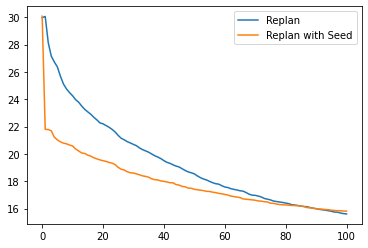

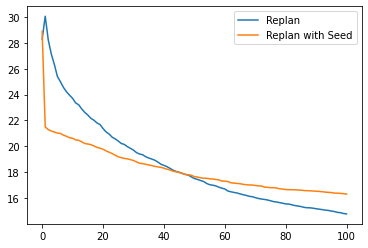

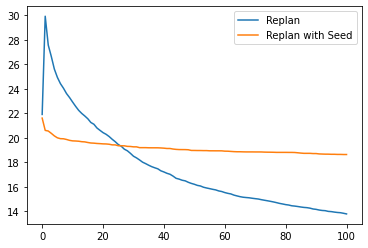

In [6]:
def plot(data):
    replan = data[data.Treatment == "Replan"]
    seed = data[data.Treatment == "Replan with Seed"]
    plt.plot(replan["Iteration"], replan["Value"], label="Replan")
    plt.plot(seed["Iteration"], seed["Value"], label="Replan with Seed")
    plt.legend() 

plot(mean[mean.Option == "1to100_recordings_addstack_DISTURBER@ADD_STACKS_FIRST_10_PERCENT_errPerDisturbance-5_bestObj.csv"])
plt.savefig("exp1_periteration_add_first.png")
plt.show()
plot(mean[mean.Option == "1to100_recordings_addstack_DISTURBER@ADD_STACKS_MIDDLE_10_PERCENT_errPerDisturbance-5_bestObj.csv"])
plt.savefig("exp1_periteration_add_middle.png")
plt.show()
plot(mean[mean.Option == "1to100_recordings_addstack_DISTURBER@ADD_STACKS_LAST_10_PERCENT_errPerDisturbance-5_bestObj.csv"])
plt.savefig("exp1_periteration_add_last.png")
plt.show()
#plt.savefig("exp1_seed_vs_no_seed.png")

#x1, mean1, bounds1 = get_stats_by_group(df1,"averageReward", "epoch", bounding_stats="ci")
#x2, mean2, bounds2 = get_stats_by_group(df2, "averageReward", "epoch", bounding_stats="ci")
#plot([x1, x2], [mean1, mean2], [bounds1[0], bounds2[0]], [bounds2[0], bounds2[1]], [ "rewards_a", "rewards_b"],
        #"Epoch", "Average Cumulative Reward", legloc="lower right", savepath=None)

## Statistical Testing

In [41]:
def get_data(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    naive_repair = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    replan = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    replan_seed = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    pre_disturbance_ov = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    post_disturbance_ov = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path, f))
            option = f.split("@")[1].split("_errPerDisturbance")[0]
            disturbance = option.split("_")[0]
            setting = option.split("_")[2]
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_naive_2" or name == "NSGAII_NaivePlanningStrategy_2" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_naive_0"):
                    for index, row in group.iterrows():
                        naive_repair = naive_repair.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['final_objective_value']},
                                     ignore_index=True)
                        pre_disturbance_ov = pre_disturbance_ov.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['initial_pre_disturbance_std']},
                                     ignore_index=True)
                        post_disturbance_ov = post_disturbance_ov.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['initial_post_disturbance_std']},
                                     ignore_index=True)
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0" or name == "NSGAII_EvaluationReplanningStrategy-10000_1" or name == "NSGAII_EvaluationReplanningStrategy-10000_0" or name == "NSGAII_PlanningStrategy-ReplanningStrategy_1"):
                    for index, row in group.iterrows():
                        replan = replan.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['final_objective_value']},
                                     ignore_index=True)
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0,10_1" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withReinit_0" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withSeed_1" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_2"):
                    for index, row in group.iterrows():
                        replan_seed = replan_seed.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['final_objective_value']},
                                     ignore_index=True)
    return (naive_repair, replan, replan_seed, pre_disturbance_ov, post_disturbance_ov)
naive_large, replan_large, seed_large, pre_disturbance_large, post_disturbance_large = get_data("exp1/fixedPlanLength/max100itemsperstack")
naive_small, replan_small, seed_small, pre_disturbance_small, post_disturbance_small = get_data("exp1/fixedPlanLength/max10itemsperstack")
    

### testing naive repair VS replan

In [46]:
def test(replan, seed):
    p_values = pd.DataFrame(columns = ["Option", "p-value"])
    row = {}
    row['Option'] = "First 10 %"
    x = seed[seed.Setting == "FIRST"]['Value'].tolist()
    y = replan[replan.Setting == "FIRST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Middle 10 %"
    x = seed[seed.Setting == "MIDDLE"]['Value'].tolist()
    y = replan[replan.Setting == "MIDDLE"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Last 10 %"
    x = seed[seed.Setting == "LAST"]['Value'].tolist()
    y = replan[replan.Setting == "LAST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    return p_values
print("Large Model - Add Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='ADD']
naive_large_add = naive_large[naive_large.Disturbance=='ADD']
display(test(replan_large_add, naive_large_add))
print("Large Model - Delete Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='REMOVE']
naive_large_add = naive_large[naive_large.Disturbance=='REMOVE']
display(test(replan_large_add, naive_large_add))
print("Small Model - Add Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='ADD']
naive_small_add = naive_small[naive_small.Disturbance=='ADD']
display(test(replan_small_add, naive_small_add))
print("Small Model - Delete Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='REMOVE']
naive_small_add = naive_small[naive_small.Disturbance=='REMOVE']
display(test(replan_small_add, naive_small_add))

Large Model - Add Stack Case


Option p-value
0   First 10 %     0.0
1  Middle 10 %     0.0
2    Last 10 %     0.0

Large Model - Delete Stack Case


Option p-value
0   First 10 %     0.0
1  Middle 10 %     0.0
2    Last 10 %     0.0

Small Model - Add Stack Case


Option p-value
0   First 10 %     0.0
1  Middle 10 %     0.0
2    Last 10 %     0.0

Small Model - Delete Stack Case


Option p-value
0   First 10 %     0.0
1  Middle 10 %     0.0
2    Last 10 %     0.0

### testing replan VS replan with seed

In [31]:
def test(replan, seed):
    p_values = pd.DataFrame(columns = ["Option", "p-value"])
    row = {}
    row['Option'] = "First 10 %"
    x = seed[seed.Setting == "FIRST"]['Value'].tolist()
    y = replan[replan.Setting == "FIRST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Middle 10 %"
    x = seed[seed.Setting == "MIDDLE"]['Value'].tolist()
    y = replan[replan.Setting == "MIDDLE"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Last 10 %"
    x = seed[seed.Setting == "LAST"]['Value'].tolist()
    y = replan[replan.Setting == "LAST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    return p_values
print("Large Model - Add Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='ADD']
seed_large_add = seed_large[seed_large.Disturbance=='ADD']
display(test(replan_large_add, seed_large_add))
print("Large Model - Delete Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='REMOVE']
seed_large_add = seed_large[seed_large.Disturbance=='REMOVE']
display(test(replan_large_add, seed_large_add))
print("Small Model - Add Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='ADD']
seed_small_add = seed_small[seed_small.Disturbance=='ADD']
display(test(replan_small_add, seed_small_add))
print("Small Model - Delete Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='REMOVE']
seed_small_add = seed_small[seed_small.Disturbance=='REMOVE']
display(test(replan_small_add, seed_small_add))

Large Model - Add Stack Case


Option   p-value
0   First 10 %  0.009942
1  Middle 10 %  0.000084
2    Last 10 %       0.0

Large Model - Delete Stack Case


Option   p-value
0   First 10 %   0.90955
1  Middle 10 %   0.22321
2    Last 10 %  0.000015

Small Model - Add Stack Case


Option   p-value
0   First 10 %  0.727872
1  Middle 10 %  0.000001
2    Last 10 %       0.0

Small Model - Delete Stack Case


Option   p-value
0   First 10 %  0.062982
1  Middle 10 %   0.00159
2    Last 10 %       0.0

### testing std before and after disturbance

In [47]:
def test(replan, seed):
    p_values = pd.DataFrame(columns = ["Option", "p-value"])
    row = {}
    row['Option'] = "First 10 %"
    x = seed[seed.Setting == "FIRST"]['Value'].tolist()
    y = replan[replan.Setting == "FIRST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="two-sided")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Middle 10 %"
    x = seed[seed.Setting == "MIDDLE"]['Value'].tolist()
    y = replan[replan.Setting == "MIDDLE"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="two-sided")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Last 10 %"
    x = seed[seed.Setting == "LAST"]['Value'].tolist()
    y = replan[replan.Setting == "LAST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="two-sided")[1]
    p_values = p_values.append(row, ignore_index = True)
    return p_values
print("Large Model - Add Stack Case")
pre_disturbance_large_add = pre_disturbance_large[pre_disturbance_large.Disturbance=='ADD']
post_disturbance_large_add = post_disturbance_large[post_disturbance_large.Disturbance=='ADD']
display(test(pre_disturbance_large_add, post_disturbance_large_add))
print("Large Model - Delete Stack Case")
pre_disturbance_large_add = pre_disturbance_large[pre_disturbance_large.Disturbance=='REMOVE']
post_disturbance_large_add = post_disturbance_large[post_disturbance_large.Disturbance=='REMOVE']
display(test(pre_disturbance_large_add, post_disturbance_large_add))
print("Small Model - Add Stack Case")
pre_disturbance_small_add = pre_disturbance_small[pre_disturbance_small.Disturbance=='ADD']
post_disturbance_small_add = post_disturbance_small[post_disturbance_small.Disturbance=='ADD']
display(test(pre_disturbance_small_add, seed_small_add))
print("Small Model - Delete Stack Case")
pre_disturbance_small_add = pre_disturbance_small[pre_disturbance_small.Disturbance=='REMOVE']
post_disturbance_small_add = post_disturbance_small[post_disturbance_small.Disturbance=='REMOVE']
display(test(pre_disturbance_small_add, post_disturbance_small_add))

Large Model - Add Stack Case


Option   p-value
0   First 10 %       0.0
1  Middle 10 %  0.000168
2    Last 10 %       0.0

Large Model - Delete Stack Case


Option   p-value
0   First 10 %   0.56922
1  Middle 10 %  0.923442
2    Last 10 %  0.876635

Small Model - Add Stack Case


Option p-value
0   First 10 %     0.0
1  Middle 10 %     0.0
2    Last 10 %     0.0

Small Model - Delete Stack Case


Option   p-value
0   First 10 %  0.325426
1  Middle 10 %  0.609998
2    Last 10 %  0.923432

# Experiment 2: Measurement of Evaluations/Time
### Predefined standard deviation ( >= 50% decrease from initial std); Search until quality is sufficient (for initial plan & when replanning after disturbance)


In [5]:
def exp2_prepare_results(folder_path, visualize=False):
    files = os.listdir(os.path.join('.', folder_path))
    mean = pd.DataFrame(columns = ["Option", "Replanning", "Replanning (seed 0.2)", "Diff to no seed"])
    std = pd.DataFrame(columns = ["Option", "Replanning", "Replanning (seed 0.2)"])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            mean_row = {}
            std_row = {}
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0"):
                    mean_row["Replanning"] = round(group['last_replanning_time'].median(), 3)
                    std_row["Replanning"] = round(group['last_replanning_time'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["last_replanning_time"], label = "Replanning")
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"):
                    mean_row["Replanning (seed 0.2)"] = round(group['last_replanning_time'].median(), 3)
                    std_row["Replanning (seed 0.2)"] = round(group['last_replanning_time'].std(), 3)
                    if visualize:
                        plt.plot(group["run"],group["last_replanning_time"],  label = "Replanning with Seed")
            #print(f)"NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1" und "NSGAII_PlanningStrategy-ReplanningStrategy_0"
           # print(mean_row)
            mean_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
            mean = mean.append(mean_row, ignore_index = True)
            std_row["Option"] = f.split("@")[1].split(".")[0]
            std = std.append(std_row, ignore_index = True)
            if visualize:
                plt.title(f.split("@")[1].split("_errPerDisturbance")[0])
                plt.legend()
                plt.show()
    print("Median - Replanning time")
    mean["Diff to no seed"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"]) / mean["Replanning"] * 100
    return (mean, std)

def visualize(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            plt.plot(df["last_replanning_evaluations"])
            plt.title(f.split("@")[1].split("_errPerDisturbance")[0])
            plt.show()

## fixed plan length (solutionLength = 200)

In [6]:
exp2_mean_simpleModel, exp2_std_simpleModel = exp2_prepare_results("exp2/fixedPlanLength/max10itemsperstack")
exp2_mean_complexModel, exp2_std_complexModel = exp2_prepare_results("exp2/fixedPlanLength/max100itemsperstack")
display(exp2_mean_complexModel)

Median - Replanning time
Median - Replanning time


Option Replanning Replanning (seed 0.2)  \
0       ADD_STACKS_LAST_10_PERCENT      54.77               298.016   
1    REMOVE_STACKS_LAST_10_PERCENT     40.989                 3.934   
2      ADD_STACKS_FIRST_10_PERCENT     84.619                97.161   
3     ADD_STACKS_MIDDLE_10_PERCENT     64.416               157.806   
4   REMOVE_STACKS_FIRST_10_PERCENT     55.921                19.651   
5  REMOVE_STACKS_MIDDLE_10_PERCENT     50.378                13.662   

  Diff to no seed  
0      444.122695  
1      -90.402303  
2        14.82173  
3      144.979508  
4      -64.859355  
5      -72.881019

## statistical testing replan VS replan with seed

In [2]:
def get_data(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    replan = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    seed = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            option = f.split("@")[1].split("_errPerDisturbance")[0]
            disturbance = option.split("_")[0]
            setting = option.split("_")[2]
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0"):
                    for index, row in group.iterrows():
                        replan = replan.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['last_replanning_evaluations']},
                                         ignore_index=True)
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"):
                    for index, row in group.iterrows():
                        seed = seed.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['last_replanning_evaluations']},
                                         ignore_index=True)
    return (replan, seed)
                    
replan_large, seed_large = get_data("exp2/fixedPlanLength/max100itemsperstack")
replan_small, seed_small = get_data("exp2/fixedPlanLength/max10itemsperstack")


In [20]:
def test(replan, seed):
    p_values = pd.DataFrame(columns = ["Option", "p-value"])
    row = {}
    row['Option'] = "First 10 %"
    x = seed[seed.Setting == "FIRST"]['Value'].tolist()
    y = replan[replan.Setting == "FIRST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Middle 10 %"
    x = seed[seed.Setting == "MIDDLE"]['Value'].tolist()
    y = replan[replan.Setting == "MIDDLE"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Last 10 %"
    x = seed[seed.Setting == "LAST"]['Value'].tolist()
    y = replan[replan.Setting == "LAST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    return p_values
print("Large Model - Add Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='ADD']
seed_large_add = seed_large[seed_large.Disturbance=='ADD']
display(test(replan_large_add, seed_large_add))
print("Large Model - Delete Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='REMOVE']
seed_large_add = seed_large[seed_large.Disturbance=='REMOVE']
display(test(replan_large_add, seed_large_add))
print("Small Model - Add Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='ADD']
seed_small_add = seed_small[seed_small.Disturbance=='ADD']
display(test(replan_small_add, seed_small_add))
print("Small Model - Delete Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='REMOVE']
seed_small_add = seed_small[seed_small.Disturbance=='REMOVE']
display(test(replan_small_add, seed_small_add))

Large Model - Add Stack Case


Option   p-value
0   First 10 %  0.001553
1  Middle 10 %  0.000002
2    Last 10 %       0.0

Large Model - Delete Stack Case


Option   p-value
0   First 10 %  0.999722
1  Middle 10 %       0.5
2    Last 10 %  0.999993

Small Model - Add Stack Case


Option   p-value
0   First 10 %  0.003334
1  Middle 10 %  0.000014
2    Last 10 %       0.0

Small Model - Delete Stack Case


Option   p-value
0   First 10 %  0.774609
1  Middle 10 %  0.914317
2    Last 10 %  0.999967

# Experiment 3: Parallel Replanning
### Predefined standard deviation ( >= 50% decrease from initial std + initialization approximate); Search until quality is sufficient (initial plan & replan after disturbance while system idle), search in parallel until Q1 = Q2 and T1 < T2

## 1. Case: Evaluatie Time (seconds')

Median - Execution time (seconds)


Option Idle Replan Parallel (2) Parallel (5)  \
0   ADD_STACKS_FIRST_10_PERCENT     519.943      526.336      486.634   
1  ADD_STACKS_MIDDLE_10_PERCENT     529.753      488.621      447.262   

  Parallel (10)  Parallel (1)  Parallel (3)  Parallel (4)  Parallel (6)  \
0       380.026       500.042       522.056       490.746       523.571   
1       300.098       497.042       516.532       487.451       440.106   

   Parallel (7)  Parallel (8)  Parallel (9)  
0       470.952       451.711       471.225  
1       385.106       320.070       300.173

Option Idle Replan Parallel (2) Parallel (5)  \
2   REMOVE_STACKS_FIRST_10_PERCENT     566.026      540.741      512.847   
3  REMOVE_STACKS_MIDDLE_10_PERCENT      683.12      570.036      433.503   

  Parallel (10)  Parallel (1)  Parallel (3)  Parallel (4)  Parallel (6)  \
2       300.177       622.209       547.719       542.034       467.065   
3       220.099       579.809       547.032       557.555       400.148   

   Parallel (7)  Parallel (8)  Parallel (9)  
2       390.097       385.143       335.093  
3       315.175       260.055       235.041

Median - Execution time relative to idle replanning (%)


Option Idle Replan Parallel (2) Parallel (5)  \
0   ADD_STACKS_FIRST_10_PERCENT     519.943     1.229558    -6.406279   
1  ADD_STACKS_MIDDLE_10_PERCENT     529.753    -7.764373   -15.571597   

  Parallel (10) Parallel (1) Parallel (3) Parallel (4) Parallel (6)  \
0    -26.910065    -3.827535     0.406391    -5.615423     0.697769   
1    -43.351335    -6.174764    -2.495691    -7.985231   -16.922415   

  Parallel (7) Parallel (8) Parallel (9)  
0    -9.422379   -13.122977    -9.369873  
1   -27.304612   -39.581277   -43.337178

Option Idle Replan Parallel (2) Parallel (5)  \
2   REMOVE_STACKS_FIRST_10_PERCENT     566.026    -4.467109    -9.395151   
3  REMOVE_STACKS_MIDDLE_10_PERCENT      683.12   -16.554046   -36.540725   

  Parallel (10) Parallel (1) Parallel (3) Parallel (4) Parallel (6)  \
2     -46.96763     9.925869    -3.234304    -4.238675   -17.483472   
3    -67.780331   -15.123404   -19.921536   -18.381104   -41.423469   

  Parallel (7) Parallel (8) Parallel (9)  
2   -31.081434   -31.956659   -40.799009  
3   -53.862425   -61.931286   -65.593014

Standard Deviation - Execution time (seconds)


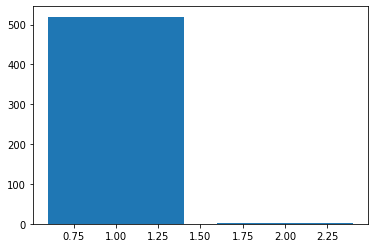

In [15]:
T = 10
plot = False
files = os.listdir(os.path.join('.', 'exp3/case_1to100'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (2)", "Parallel (5)", "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns =  ["Option", "Idle Replan",  "Parallel (2)", "Parallel (5)", "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'exp3/case_1to100', f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'exp3/case_1to100', "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        df_p['run'] = df_p['run'].map(int)/3
        df_p['run'] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"] + df["last_replanning_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =  df_p["pred_plan_steps_execution_time"] + df_p["pred_plan_runtime"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)#/mean_executiontime_row["Idle Replan"]*100            
            if plot:
                plt.plot(g["run"], g["overall_execution_time"], label = "Idle Replan")
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)#/mean_executiontime_row[f"Parallel ({name[1]})"]*100
            if plot:
                plt.plot(group["run"], group["pred_overall_execution_time"], label=f"Parallel ({name[1]})")
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)
        if plot:
            plt.legend()
            plt.title(mean_executiontime_row["Option"])
            plt.show()
        
print("Median - Execution time (seconds)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:4, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Execution time relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:4, :])

plt.bar([1, 2], overall_runtime.iloc[0, 1:3])

print("Standard Deviation - Execution time (seconds)")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]



## Charts

Option     1 Step    2 Steps    3 Steps  \
0      ADD_STACKS_FIRST_10_PERCENT  -3.827535   1.229558   0.406391   
1     ADD_STACKS_MIDDLE_10_PERCENT  -6.174764  -7.764373  -2.495691   
2   REMOVE_STACKS_FIRST_10_PERCENT   9.925869  -4.467109  -3.234304   
3  REMOVE_STACKS_MIDDLE_10_PERCENT -15.123404 -16.554046 -19.921536   

     4 Steps    5 Steps    6 Steps    7 Steps    8 Steps    9 Steps   10 Steps  
0  -5.615423  -6.406279   0.697769  -9.422379 -13.122977  -9.369873 -26.910065  
1  -7.985231 -15.571597 -16.922415 -27.304612 -39.581277 -43.337178 -43.351335  
2  -4.238675  -9.395151 -17.483472 -31.081434 -31.956659 -40.799009  -46.96763  
3 -18.381104 -36.540725 -41.423469 -53.862425 -61.931286 -65.593014 -67.780331

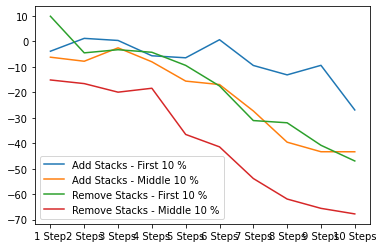

In [48]:
parallel_executions = pd.DataFrame(columns=["Option", "1 Step", "2 Steps", "3 Steps", "4 Steps", "5 Steps", "6 Steps", "7 Steps", "8 Steps", "9 Steps", "10 Steps"])
parallel_executions["Option"] = overall_runtime["Option"]
parallel_executions["1 Step"] = overall_runtime["Parallel (1)"]
parallel_executions["2 Steps"] = overall_runtime["Parallel (2)"]
parallel_executions["3 Steps"] = overall_runtime["Parallel (3)"]
parallel_executions["4 Steps"] = overall_runtime["Parallel (4)"]
parallel_executions["5 Steps"] = overall_runtime["Parallel (5)"]
parallel_executions["6 Steps"] = overall_runtime["Parallel (6)"]
parallel_executions["7 Steps"] = overall_runtime["Parallel (7)"]
parallel_executions["8 Steps"] = overall_runtime["Parallel (8)"]
parallel_executions["9 Steps"] = overall_runtime["Parallel (9)"]
parallel_executions["10 Steps"] = overall_runtime["Parallel (10)"]
display(parallel_executions)
plt.plot(parallel_executions.iloc[0, 1:], label="Add Stacks - First 10 %")
plt.plot(parallel_executions.iloc[1, 1:], label="Add Stacks - Middle 10 %")
plt.plot(parallel_executions.iloc[2, 1:], label="Remove Stacks - First 10 %")
plt.plot(parallel_executions.iloc[3, 1:], label="Remove Stacks - Middle 10 %")
plt.legend()
plt.savefig("exp3_parallel_linechart.png")
plt.show()
#parallel_executions.iloc[0, 1:].plot.line()

## 2. Case: Compare ONLY execution steps of new plan

In [55]:
T = 10
files = os.listdir(os.path.join('.', 'exp3'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (2)", "Parallel (5)", "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns =  ["Option", "Idle Replan",  "Parallel (2)", "Parallel (5)", "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'exp3', f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'exp3', "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        df_p['run'] = df_p['run'].map(int)/3
        df_p["run"] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =   df_p["pred_plan_steps_execution_time"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)/mean_executiontime_row["Idle Replan"]*100            
            
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)/mean_executiontime_row[f"Parallel ({name[1]})"]*100
   
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)

        
print("Median - Number of Evaluations")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Number of Evaluations relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

print("Standard Deviation - Number of Evaluations")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]


display(overall_runtime_std.iloc[:2, :])
display(overall_runtime_std.iloc[2:, :])
# todo: create table for each rq
# todo: create plot for each rq

# todo: in den CSVs: naive Planning -> naive Repair

Median - Number of Evaluations


Option Idle Replan Parallel (2) Parallel (5)  \
0   ADD_STACKS_FIRST_10_PERCENT        41.5         45.5         51.0   
1  ADD_STACKS_MIDDLE_10_PERCENT        48.0         41.0         42.5   

  Parallel (10)  
0          32.0  
1          28.0

Option Idle Replan Parallel (2) Parallel (5)  \
2   REMOVE_STACKS_FIRST_10_PERCENT        49.5         47.0         40.0   
3  REMOVE_STACKS_MIDDLE_10_PERCENT        53.0         53.0         44.0   

  Parallel (10)  
2          19.0  
3          14.0

Median - Number of Evaluations relative to idle replanning (%)


Option Idle Replan Parallel (2) Parallel (5)  \
0   ADD_STACKS_FIRST_10_PERCENT        41.5     9.638554    22.891566   
1  ADD_STACKS_MIDDLE_10_PERCENT        48.0   -14.583333   -11.458333   

  Parallel (10)  
0    -22.891566  
1    -41.666667

Option Idle Replan Parallel (2) Parallel (5)  \
2   REMOVE_STACKS_FIRST_10_PERCENT        49.5    -5.050505   -19.191919   
3  REMOVE_STACKS_MIDDLE_10_PERCENT        53.0          0.0   -16.981132   

  Parallel (10)  
2    -61.616162  
3    -73.584906

Standard Deviation - Number of Evaluations


Option Idle Replan Parallel (2) Parallel (5)  \
0   ADD_STACKS_FIRST_10_PERCENT   38.024096    25.358242    38.988235   
1  ADD_STACKS_MIDDLE_10_PERCENT   32.945833    45.763415    38.675294   

  Parallel (10)  
0      46.31875  
1     72.142857

Option Idle Replan Parallel (2) Parallel (5)  \
2   REMOVE_STACKS_FIRST_10_PERCENT   38.925253    33.546809        39.63   
3  REMOVE_STACKS_MIDDLE_10_PERCENT   31.175472    45.532075    52.463636   

  Parallel (10)  
2     34.036842  
3     74.021429